# Import semua Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector

# Load Data

In [2]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


##  Basic Exploration
- Record Data
- Missing Value
- Range Data
- Describe Data

In [3]:
print(df.info())

# Statistik dasar
print(df.describe())

# Cek missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2788 entries, 0 to 2787
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2788 non-null   object 
 1   Open       2788 non-null   float64
 2   High       2788 non-null   float64
 3   Low        2788 non-null   float64
 4   Close      2788 non-null   float64
 5   Adj Close  2788 non-null   float64
 6   Volume     2788 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 152.6+ KB
None
               Open          High           Low         Close     Adj Close  \
count   2788.000000   2788.000000   2788.000000   2788.000000   2788.000000   
mean   12114.051628  12432.075536  11764.920824  12126.416572  12126.416572   
std    16612.538889  17044.777808  16119.346993  16615.381435  16615.381435   
min      176.897003    211.731003    171.509995    178.102997    178.102997   
25%      612.573471    618.876495    609.665756    613.742477    613.7

## Visualize Data
- Plot harga dari waktu ke waktu

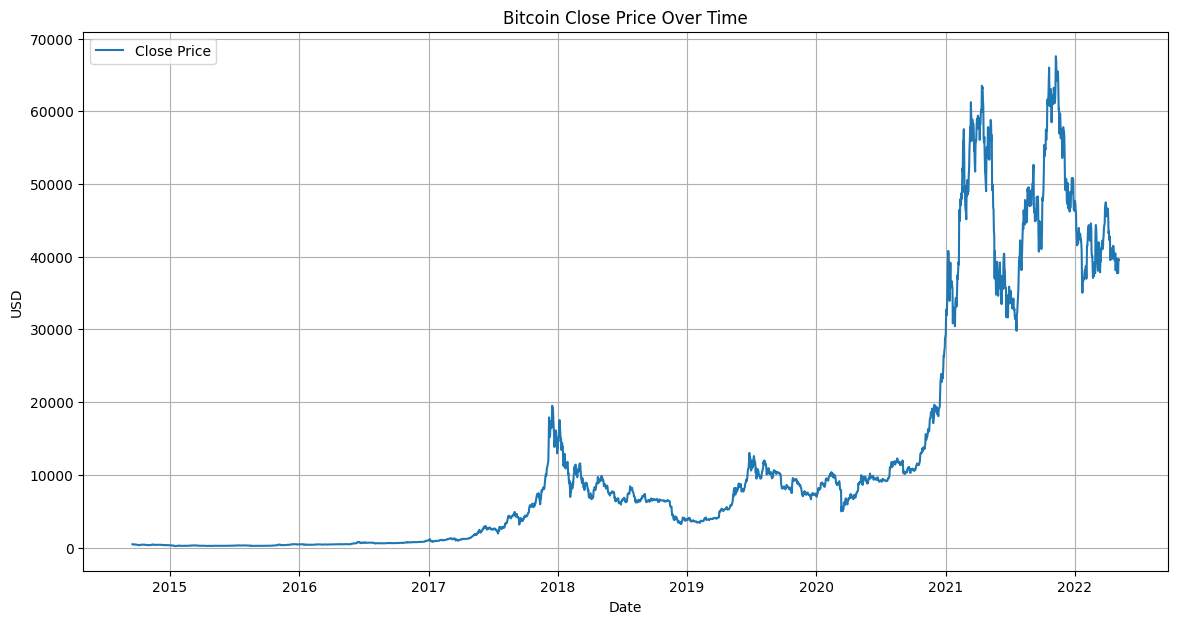

In [4]:

# Pastikan kolom Date jadi tipe datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date jadi index
df.set_index('Date', inplace=True)

# Plot harga penutupan (Close)
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()

Plot Semua Harga

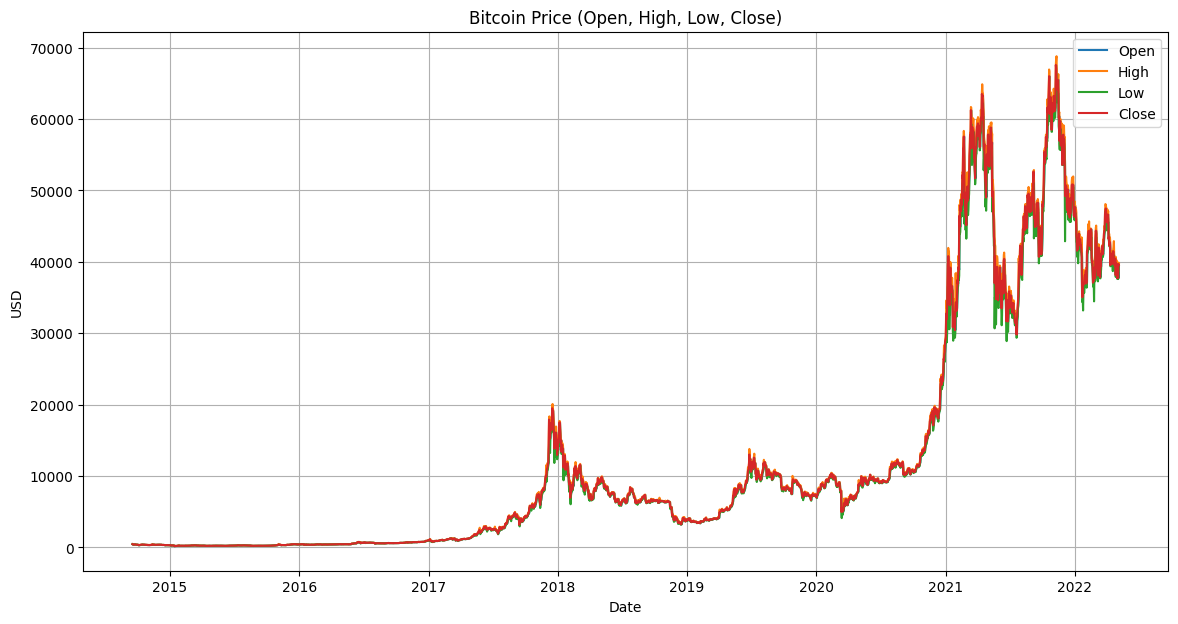

In [5]:
# Plot semua harga
plt.figure(figsize=(14,7))
plt.plot(df['Open'], label='Open')
plt.plot(df['High'], label='High')
plt.plot(df['Low'], label='Low')
plt.plot(df['Close'], label='Close')
plt.title('Bitcoin Price (Open, High, Low, Close)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()


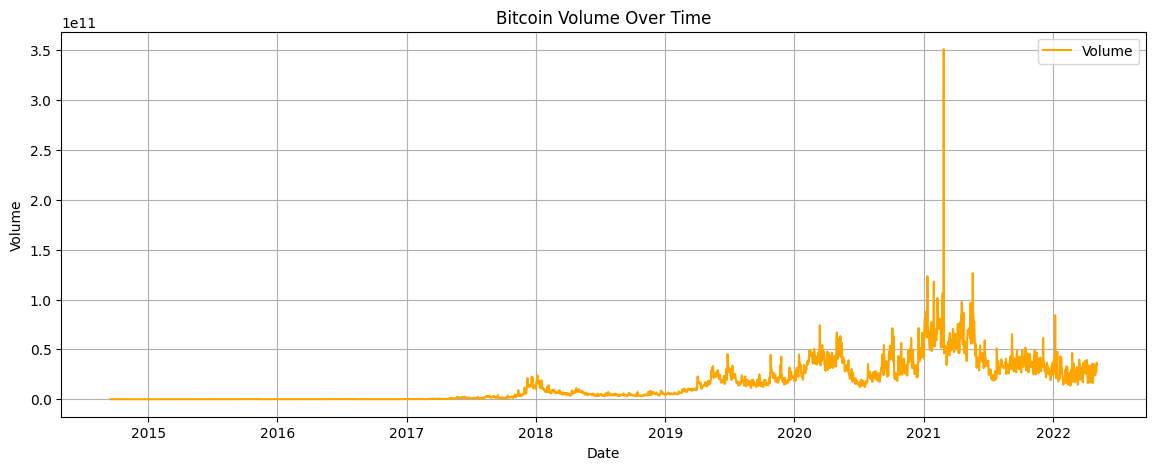

In [6]:
# Volume transaksi
plt.figure(figsize=(14,5))
plt.plot(df['Volume'], color='orange', label='Volume')
plt.title('Bitcoin Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


- Cek Korelasi antar fitur numerik
- Cek trend seasonal 30 hari / 1 bulan


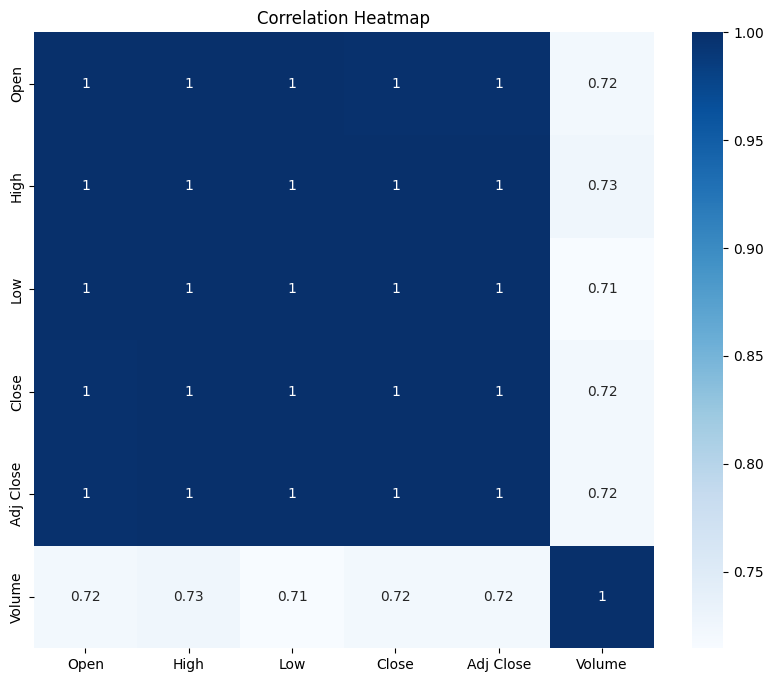

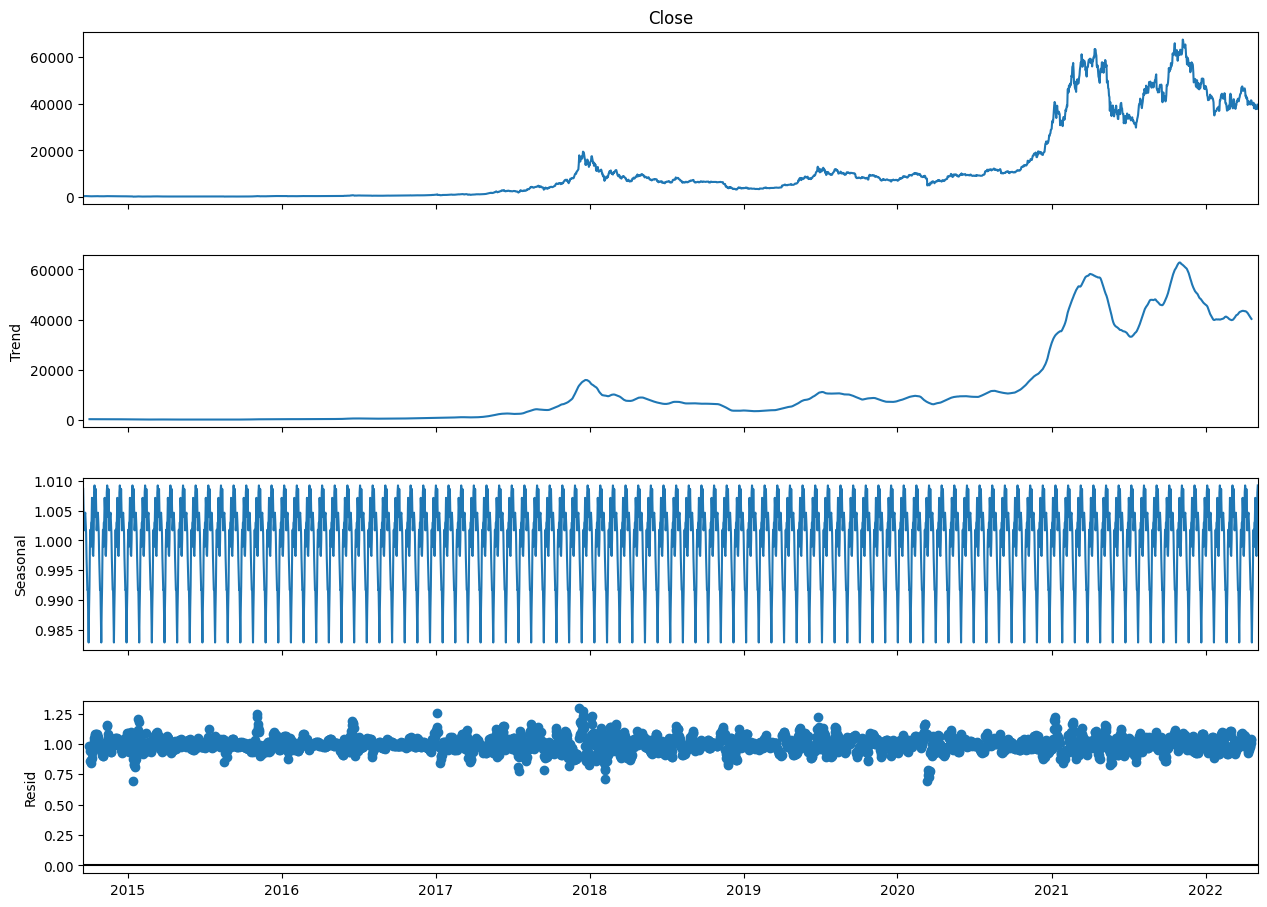

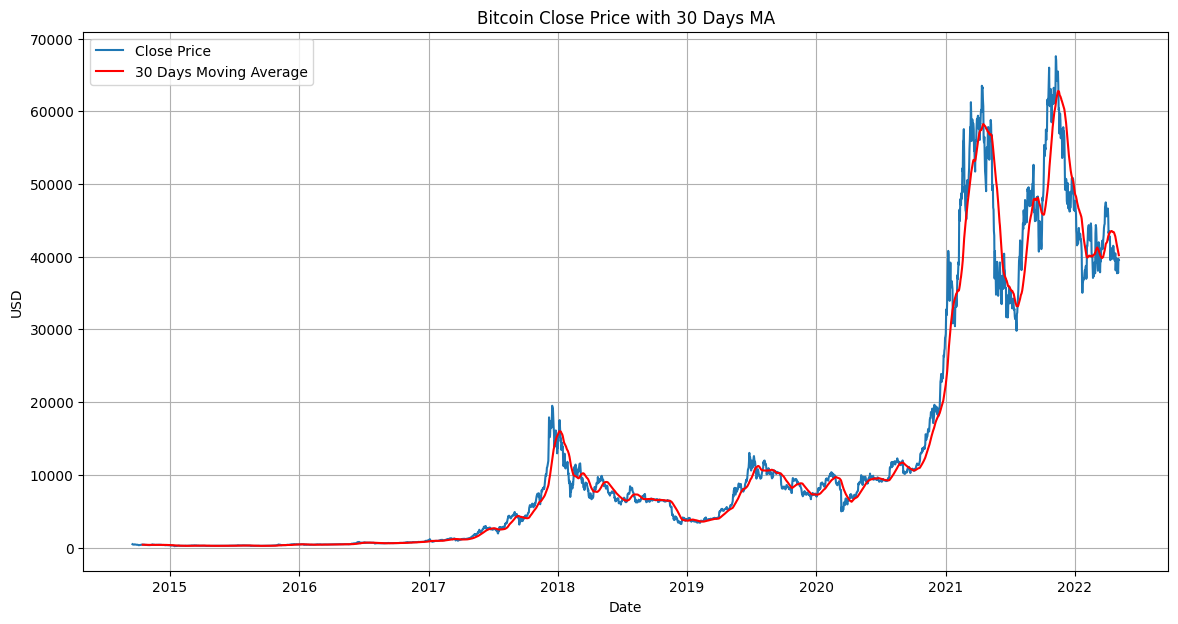

In [7]:

# Heatmap Korelasi antar fitur
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

# Seasonal Decomposition
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)  # Asumsi period bulanan
fig = result.plot()
fig.set_size_inches(14, 10)
plt.show()

# Moving Average (30 hari)
df['Close_MA30'] = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Close_MA30'], label='30 Days Moving Average', color='red')
plt.title('Bitcoin Close Price with 30 Days MA')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
plt.show()


## Data Preprocessing Untuk Modelling

Kita akan menggunakan 60 hari sebelumnya untuk memprediksi hari berikutnya

- Pisahkan dulu data train dan test karena train akan kita normalisasikan

- Normalisasi data numeric tersebut
(Ambil data numerik dengan drop kolom date, kemudian ubah dengan minmaxscaler)

In [8]:
# Fokus pada beberapa fitur untuk multivariate prediction
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features]

# 2. Scaling data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

Buat Windowed Datasets untuk Time Series

In [9]:
# Membentuk dataset windowed
sequence_length = 60  # Menggunakan 60 hari sebagai input
forecast_horizon = 30   # Memprediksi 7 hari ke depan

X = []
y = []
for i in range(sequence_length, len(scaled_data) - forecast_horizon + 1):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i:i+forecast_horizon])

X, y = np.array(X), np.array(y)

## Membuat Model Deep Learning

- Membuat Dataset dari data yang sudah di-windowing untuk Model 

- Buat Model dari LSTM

In [10]:
# Membuat model LSTM multivariate multi-step
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(RepeatVector(forecast_horizon))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(len(features))))

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\Fariz\.virtualenvs\submission_predictive_analysis-m32BVzw4\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- Latih model dengan LSTM, optimizer adam

In [11]:
# 5. Melatih model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)


# 6. Prediksi
train_pred = model.predict(X)  # (samples, forecast_horizon, features)

# Inverse transform manual per step
train_pred_unscaled = []
y_unscaled = []

for i in range(train_pred.shape[0]):
    pred_window = scaler.inverse_transform(train_pred[i])
    true_window = scaler.inverse_transform(y[i])
    train_pred_unscaled.append(pred_window)
    y_unscaled.append(true_window)

train_pred_unscaled = np.array(train_pred_unscaled)
y_unscaled = np.array(y_unscaled)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 0.0179 - val_loss: 0.0227
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0025 - val_loss: 0.0123
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0019 - val_loss: 0.0105
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0016 - val_loss: 0.0097
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0015 - val_loss: 0.0108
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0011 - val_loss: 0.0086
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0012 - val_loss: 0.0083
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0012 - val_loss: 0.0211
Epoch 10/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0014 - val_loss: 0.0079
Epoch 11/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 9.7339e-04 - val_loss: 0.0097
Epoch 12/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss:

- Visualize prediksi hari ke 30

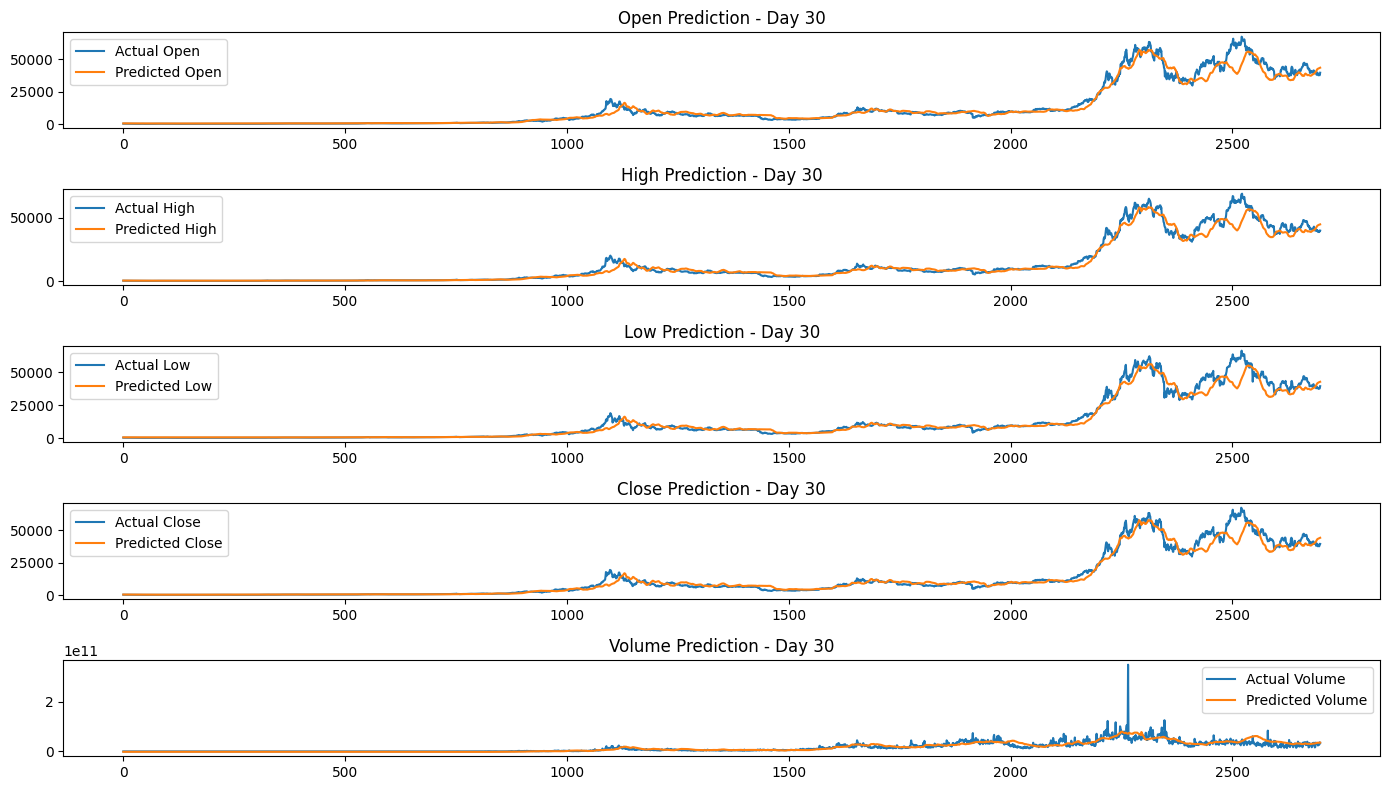

In [12]:
plt.figure(figsize=(14, 8))
for idx, feat in enumerate(features):
    plt.subplot(len(features), 1, idx+1)
    plt.plot(y_unscaled[:, 29, idx], label=f'Actual {feat}')
    plt.plot(train_pred_unscaled[:, 29, idx], label=f'Predicted {feat}')
    plt.legend()
    plt.title(f'{feat} Prediction - Day {29+1}')
plt.tight_layout()
plt.show()


- Menggunakan model GRU dan Callback

In [14]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('mae') < 0.055 and logs.get('val_mae') < 0.055):
                self.model.stop_training = True
 
callbacks = myCallback()

In [16]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(RepeatVector(forecast_horizon))
model.add(GRU(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(len(features))))

model.compile(optimizer='adam', loss='mae', metrics=["mae"])

#  Melatih model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1,
          callbacks=callbacks,)

#  Prediksi dan Plot seperti sebelumnya
train_pred = model.predict(X)

Epoch 1/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0520 - mae: 0.0520 - val_loss: 0.0901 - val_mae: 0.0901
Epoch 2/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0194 - mae: 0.0194 - val_loss: 0.0719 - val_mae: 0.0719
Epoch 3/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0170 - mae: 0.0170 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 4/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0166 - mae: 0.0166 - val_loss: 0.0612 - val_mae: 0.0612
Epoch 5/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0616 - val_mae: 0.0616
Epoch 6/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0161 - mae: 0.0161 - val_loss: 0.0683 - val_mae: 0.0683
Epoch 7/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0152 - mae: 0.0152 - val_loss: 0.0610 - val_mae: 0.0610
Epoch 8/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0606 - val_mae: 0.0606
Epoch 9/20
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.015

- Visualize hari ke 30

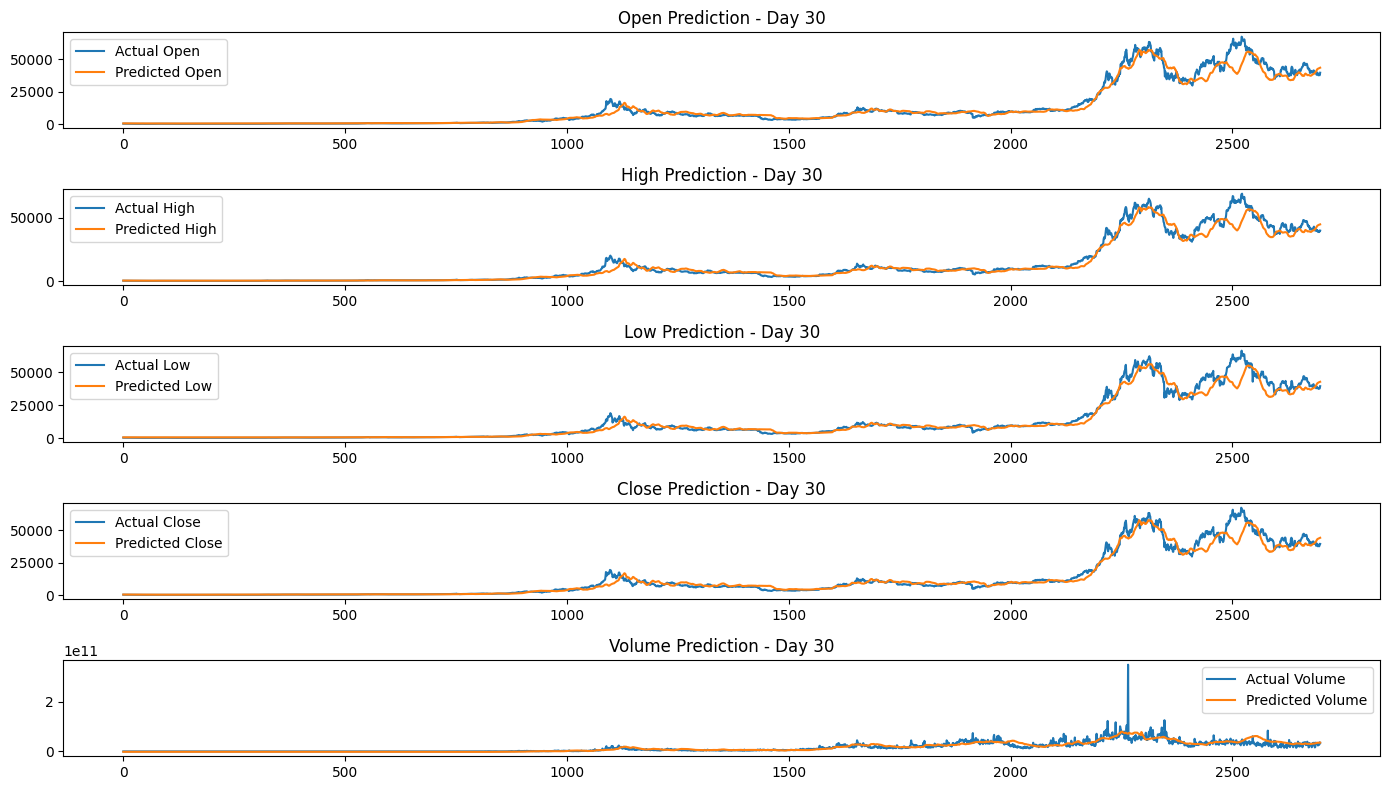

In [17]:
plt.figure(figsize=(14, 8))
for idx, feat in enumerate(features):
    plt.subplot(len(features), 1, idx+1)
    plt.plot(y_unscaled[:, 29, idx], label=f'Actual {feat}')
    plt.plot(train_pred_unscaled[:, 29, idx], label=f'Predicted {feat}')
    plt.legend()
    plt.title(f'{feat} Prediction - Day {29+1}')
plt.tight_layout()
plt.show()
